<br>

<br>

# **MODELO ADABOOST** 🤖

<br>

## **ÍNDICE**

- **PASO 1: LIBRERÍAS**
- **PASO 2: LECTURA Y VISUALIZACIÓN DEL DATASET**
- **PASO 3: DIVISIÓN DE DATOS TRAIN/TEST**
- **PASO 4: ESCALADO NUMÉRICO**
- **PASO 5: CODIFICACIÓN ONE-HOT (TRAIN/TEST)**
- **PASO 6: MODELO ADABOOST**
- **PASO 7: ENTRENAMIENTO ADABOOST**
- **PASO 8: PREDICCIONES TEST**
- **PASO 9: PREDICCIONES TRAIN**
- **PASO 10: MÉTRICAS ADABOOST**
- **PASO 11: GUARDAR MODELO ADABOOST**

<br>

<br>

## **PASO 1: LIBRERÍAS**

In [25]:
import os
import joblib
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.ensemble import AdaBoostClassifier
import warnings
warnings.filterwarnings('ignore')


<br>

## **PASO 2: LECTURA Y VISUALIZACIÓN DEL DATASET**

In [26]:
df = pd.read_csv('/workspaces/DETECCION-FRAUDE-BANCARIO/src/Base_100milfilas.csv')
df.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,0,0.9,0.475015,-1,67,50,0.008162,-0.947659,AB,2998,...,0,1500.0,0,INTERNET,2.892488,other,1,1,0,0
1,0,0.8,0.723322,23,9,30,0.038436,-1.764405,AB,859,...,0,1000.0,0,INTERNET,1.260981,windows,1,1,0,0
2,0,0.5,0.032770,-1,30,40,0.013338,-1.254882,AB,2689,...,0,200.0,1,INTERNET,16.785044,linux,0,1,0,0
3,1,0.9,0.570800,-1,157,60,0.005908,35.337538,AA,4079,...,0,1500.0,0,INTERNET,4.036394,windows,1,1,0,0
4,0,0.5,0.743169,-1,41,50,0.012817,14.357233,AA,3527,...,1,500.0,0,INTERNET,38.482143,other,0,1,0,0


<br>

## **PASO 3: DIVISIÓN DE DATOS TRAIN/TEST**

In [27]:
print("DIVISIÓN DEL CONJUNTO DE DATOS EN ENTRENAMIENTO Y PRUEBA\n")
# Se dividen el conjunto de datos en muestras de train y test
X = df.drop("fraud_bool", axis = 1)
y = df["fraud_bool"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

X_train.head()

DIVISIÓN DEL CONJUNTO DE DATOS EN ENTRENAMIENTO Y PRUEBA



,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,velocity_6h,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
75220,0.6,0.270506,-1,26,30,0.021974,-0.264050,AB,1399,3799.505949,...,0,200.0,0,INTERNET,4.740897,macintosh,1,1,0,5
48955,0.9,0.150723,-1,96,40,0.807552,-1.630215,AC,912,4547.412245,...,0,200.0,0,INTERNET,8.143705,windows,0,2,0,3
44966,0.4,0.425121,-1,205,20,0.010792,13.220485,AA,1927,8501.804609,...,1,500.0,0,INTERNET,7.486885,linux,0,1,0,3
13568,0.8,0.133088,-1,59,20,5.918782,2.706204,AA,1511,3014.081394,...,0,200.0,0,INTERNET,8.280017,other,0,1,0,1
92727,0.4,0.163981,-1,37,40,0.007141,-0.649811,AC,542,6048.521121,...,0,200.0,0,INTERNET,9.077518,linux,1,1,0,7


<br>

## **PASO 4: ESCALADO NUMÉRICO**

In [28]:
print("SE HAN IDENTIFICADO Y ESCALADO LAS VARIABLES NUMÉRICAS - EXCLUYENDO LA VARIABLE OBJETIVO\n")
# Identifico las variables numéricas automáticamente, excluyendo 'fraud_bool' 
variables_numericas = [col for col in df.columns if pd.api.types.is_numeric_dtype(df[col]) and col != 'fraud_bool']

# Instancio el escalador
scaler = StandardScaler()

# Entreno el escalador con los datos de entrenamiento
scaler.fit(X_train[variables_numericas])

# Aplico el escalador en los datos de entrenamiento
X_train_final = scaler.transform(X_train[variables_numericas])
X_train_final = pd.DataFrame(X_train_final, index=X_train.index, columns=variables_numericas)

# Aplico el escalador en los datos de prueba
X_test_final = scaler.transform(X_test[variables_numericas])
X_test_final = pd.DataFrame(X_test_final, index=X_test.index, columns=variables_numericas)

# Muestro las primeras filas de los datos escalados de entrenamiento
X_train_final.head()

SE HAN IDENTIFICADO Y ESCALADO LAS VARIABLES NUMÉRICAS - EXCLUYENDO LA VARIABLE OBJETIVO



,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,...,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,session_length_in_minutes,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
75220,0.087928,-0.729357,-0.385007,-0.715763,-0.356487,-0.187864,-0.423236,-0.176144,-0.609737,0.485570,...,0.361737,1.575640,-0.516415,-0.675693,-0.170075,-0.350447,0.905860,-0.121822,0.0,0.760499
48955,1.119997,-1.139668,-0.385007,0.073872,0.453849,-0.042878,-0.491750,-0.661163,-0.360815,0.138260,...,0.361737,-0.966666,-0.516415,-0.675693,-0.170075,0.058983,-1.103924,4.878555,0.0,-0.138928
44966,-0.600118,-0.199731,-0.385007,1.303445,-1.166824,-0.189927,0.253023,0.349708,0.955303,0.144296,...,-2.764436,1.411620,1.936427,-0.090788,-0.170075,-0.020046,-1.103924,-0.121822,0.0,-0.138928
13568,0.775974,-1.200076,-0.385007,-0.343506,-1.166824,0.900445,-0.274275,-0.064600,-0.871145,0.315913,...,-2.764436,-0.064557,-0.516415,-0.675693,-0.170075,0.075384,-1.103924,-0.121822,0.0,-1.038355
92727,-0.600118,-1.094254,-0.385007,-0.591677,0.453849,-0.190601,-0.442582,-1.029658,0.138790,-1.316091,...,0.361737,-0.966666,-0.516415,-0.675693,-0.170075,0.171341,0.905860,-0.121822,0.0,1.659926


<br>

## **PASO 5: CODIFICACIÓN ONE-HOT (TRAIN/TEST)**

In [29]:
print("SE HAN IDENTIFICADO Y CODIFICADO LAS VARIABLES CATEGÓRICAS\n")
# Identificar las variables categóricas
columnas_categoricas = [col for col in X_train.columns if X_train[col].dtype == 'object']

# Instanciar el OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first')  # usar sparse_output en lugar de sparse

# Ajustar el OneHotEncoder a los datos de entrenamiento y transformar tanto train como test
X_train_categ = encoder.fit_transform(X_train[columnas_categoricas])
X_test_categ = encoder.transform(X_test[columnas_categoricas])

# Convertir a DataFrames y añadir al conjunto original
X_train_categ = pd.DataFrame(X_train_categ, columns=encoder.get_feature_names_out(columnas_categoricas), index=X_train.index)
X_test_categ = pd.DataFrame(X_test_categ, columns=encoder.get_feature_names_out(columnas_categoricas), index=X_test.index)

# Eliminar las variables categóricas originales del DataFrame
X_train = X_train.drop(columnas_categoricas, axis=1)
X_test = X_test.drop(columnas_categoricas, axis=1)

# Concatenar las nuevas variables dummy con el DataFrame original
X_train = pd.concat([X_train, X_train_categ], axis=1)
X_test = pd.concat([X_test, X_test_categ], axis=1)


SE HAN IDENTIFICADO Y CODIFICADO LAS VARIABLES CATEGÓRICAS



<br>

## **PASO 6: MODELO ADABOOST**

In [30]:
print("MODELO CON LOS DIFERENTES BOOSTING\n")
model1_ada = AdaBoostClassifier(n_estimators=200, learning_rate=0.1, random_state=42)

MODELO CON LOS DIFERENTES BOOSTING



<br>

## **PASO 7: ENTRENAMIENTO ADABOOST**

In [31]:
print("ENTRENAMIENTO DE MODELO\n")
model1_ada.fit(X_train, y_train)

ENTRENAMIENTO DE MODELO



AdaBoostClassifier(learning_rate=0.1, n_estimators=200, random_state=42)

<br>

## **PASO 8: PREDICCIONES TEST**

In [32]:
print("PREDICCIONES EN EL TEST\n")
ada_y_pred_test = model1_ada.predict(X_test)
print(ada_y_pred_test)

PREDICCIONES EN EL TEST

[0 0 0 ... 0 0 0]


<br>

## **PASO 9: PREDICCIONES TRAIN**

In [33]:
print("PREDICCIONES EN EL TRAIN\n")
ada_y_pred_train = model1_ada.predict(X_train)
print(ada_y_pred_train)

PREDICCIONES EN EL TRAIN

[0 1 0 ... 0 0 0]


<br>

## **PASO 10: MÉTRICAS ADABOOST**

In [34]:
print("MÉTRICAS TANTO EN TRAIN COMO EL TEST:\n")

ada_accuracy_test = accuracy_score(y_test, ada_y_pred_test)
ada_accuracy_train = accuracy_score(y_train, ada_y_pred_train)

print('Métricas del AdaBoost')
print("Accuracy Test AdaBoost Inicial: ", ada_accuracy_test)
print("Accuracy Train AdaBoost Inicial: ", ada_accuracy_train)

MÉTRICAS TANTO EN TRAIN COMO EL TEST:

Métricas del AdaBoost
Accuracy Test AdaBoost Inicial:  0.8941
Accuracy Train AdaBoost Inicial:  0.895525


In [35]:
# Realizar predicciones con el model1_adao entrenado
y_train_pred = model1_ada.predict(X_train)
y_test_pred = model1_ada.predict(X_test)


# Calcular métricas en el conjunto de prueba
accuracy_test = accuracy_score(y_test, y_test_pred)
f1_score_test = f1_score(y_test, y_test_pred)
precision_test = precision_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred)

# Calcular métricas en el conjunto de entrenamiento
accuracy_train = accuracy_score(y_train, y_train_pred)
f1_score_train = f1_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred)
recall_train = recall_score(y_train, y_train_pred)

# Mostrar métricas
print("Accuracy Test AdaBoost: ", accuracy_test)
print("F1-score Test AdaBoost: ", f1_score_test)
print("Precision Test AdaBoost: ", precision_test)
print("Recall Test AdaBoost: ", recall_test)

print("Accuracy Train AdaBoost: ", accuracy_train)
print("F1-score Train AdaBoost: ", f1_score_train)
print("Precision Train AdaBoost: ", precision_train)
print("Recall Train AdaBoost: ", recall_train)


Accuracy Test AdaBoost:  0.8941
F1-score Test AdaBoost:  0.11454849498327759
Precision Test AdaBoost:  0.8782051282051282
Recall Test AdaBoost:  0.061270125223613595
Accuracy Train AdaBoost:  0.895525
F1-score Train AdaBoost:  0.11198470038249043
Precision Train AdaBoost:  0.851373182552504
Recall Train AdaBoost:  0.059934038439667915


<br>

## **PASO 11: GUARDAR MODELO ADABOOST**

In [36]:
# Definir la ruta donde se guardará el modelo
ruta_modelo = '/workspaces/DETECCION-FRAUDE-BANCARIO/models/saved_models/adaboost_model.pkl'

# Verificar si el directorio existe, si no, crearlo
directorio = os.path.dirname(ruta_modelo)
if not os.path.exists(directorio):
    os.makedirs(directorio)

# Guardar el modelo AdaBoost
joblib.dump(model1_ada, ruta_modelo)

print(f"Modelo guardado en: {ruta_modelo}")

Modelo guardado en: /workspaces/DETECCION-FRAUDE-BANCARIO/models/saved_models/adaboost_model.pkl


<br>

<br>

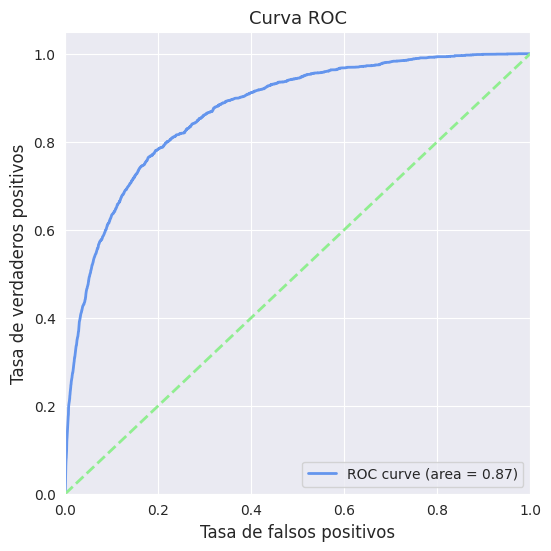

In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(model, X_test, y_test):
    """
    Genera la Curva ROC y calcula el Área Bajo la Curva (AUC) con una estética mejorada.
    """
    # Obtener probabilidades para la clase positiva
    y_probs = model.predict_proba(X_test)[:, 1]

    # Calcular la Curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)

    # Crear DataFrame para la gráfica
    df_roc = pd.DataFrame({'FPR': fpr, 'TPR': tpr})

    # Estilo de la gráfica
    sns.set_style("darkgrid")  # Fondo gris estilo la imagen proporcionada
    plt.figure(figsize=(6, 6))

    # Línea ROC principal
    sns.lineplot(x='FPR', y='TPR', data=df_roc, color='cornflowerblue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')

    # Línea diagonal de referencia
    plt.plot([0, 1], [0, 1], linestyle="--", color="lightgreen", lw=2)

    # Ajustes de ejes y etiquetas
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de falsos positivos', fontsize=12)
    plt.ylabel('Tasa de verdaderos positivos', fontsize=12)
    plt.title('Curva ROC', fontsize=13)
    plt.legend(loc="lower right", fontsize=10)

    # Mostrar la gráfica
    plt.show()

# Llamar a la función con el modelo correcto
plot_roc_curve(model1_ada, X_test, y_test)
